## 1.1 Different categories of finetuning


* The most common ways of fine-tuning a language model are `instruction fine-tuning` and `classification fine-tuning`.
* Instruction fine-tuning involves training a language model on a set of tsks using specific instructions to improve its ability to understand and execute tasks.
* Classification fine-tuning is a concept whereby the model is trained to recognize a specific set of class labels.

## 1.2 Preparing the dataset

In [76]:
##downloading and unzipping the dataset
import urllib.request
import zipfile
import os
from pathlib import Path
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_extract(url,zip_path,extracted_path,data_file_path):
  if data_file_path.exists():
    print(f"{data_file_path},already exists. Skipping download")
    return

  with urllib.request.urlopen(url) as response:
    with open(zip_path,"wb") as out_file:
      out_file.write(response.read())

    with zipfile.ZipFile(zip_path,"r") as zip_ref:
      zip_ref.extractall(extracted_path)

    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path,data_file_path)
    print(f"File donwload and saved as {data_file_path}")

download_and_extract(url,zip_path,extracted_path,data_file_path)

sms_spam_collection/SMSSpamCollection.tsv,already exists. Skipping download


In [77]:
import pandas as pd
df = pd.read_csv(data_file_path,sep="\t",header=None,names=["Label","Text"])
df = pd.DataFrame(df)
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [78]:
##examining class label distribution
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


In [79]:
#creating a balanced dataset
def balanced_dataset(df):
  num_spam = df[df["Label"]== "spam"].shape[0]
  ham_subset = df[df["Label"]=="ham"].sample(num_spam,random_state=123)
  balanced_df = pd.concat([ham_subset,df[df["Label"] == "spam"]])
  return balanced_df

balanced_df = balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [80]:
##converting labels into integers
balanced_df["Label"] = balanced_df["Label"].map({"ham":0,"spam":1})

In [81]:
##splitting the dataset
def random_split(df,train_frac,validation_frac):
  df = df.sample(
      frac=1,random_state=123
  ).reset_index(drop=True)
  train_end = int(len(df)* train_frac)
  validation_end = train_end + int(len(df)*validation_frac)

  train_df = df[:train_end]
  validation_df = df[train_end:validation_end]
  test_df = df[validation_end:]

  return train_df,validation_df,test_df

train_df,validation_df,test_df= random_split(balanced_df,0.7,0.1)

In [82]:
#saving the dataset as CSV
train_df.to_csv("train.csv",index=None)
validation_df.to_csv("validation.csv",index=None)
test_df.to_csv("test.csv",index=None)

## 1.3 Creating dataLoaders


In [83]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>",allowed_special={"<|endoftext|>"}))

[50256]


In [84]:
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
  def __init__(self,csv_file,tokenizer,max_length=None,pad_token_id=50256):
    self.data = pd.read_csv(csv_file)
    self.encoded_texts = [
        tokenizer.encode(text) for text in self.data["Text"]
    ]
    if max_length is None:
      self.max_length = self._longest_encoded_length()
    else:
      self.max_length = max_length
      self.encoded_texts = [
          encoded_text[:self.max_length] for encoded_text in self.encoded_texts
      ]

    self.encoded_texts = [
        encoded_text + [pad_token_id]* (self.max_length - len(encoded_text)) for encoded_text in self.encoded_texts
    ]


  def __getitem__(self,index):
    encoded = self.encoded_texts[index]
    label = self.data.iloc[index]["Label"]
    return (
        torch.tensor(encoded),
        torch.tensor(label)
    )

  def __len__(self):
    return len(self.data)

  def _longest_encoded_length(self):
    max_length = 0
    for encoded_text in self.encoded_texts:
      encoded_length = len(encoded_text)
      if encoded_length >max_length:
        max_length = encoded_length
    return max_length

* The class above loads data from the CSV files we created earlier, tokenizes the text using the GPT-2 tokenizer, and allows us to pad or truncate the sequneces to a uniform length determined by either the longest sequence or a predefined maximum length.

In [85]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

In [86]:
print(train_dataset.max_length)

120


* Code shows 10,meaning the longest sequence contains no more than 10 tokens.
* Next we pad the validation and test samples exceeding the length of the longest training example.

In [87]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

In [88]:
##creating a pytorch dataloader
from torch.utils.data import DataLoader

num_workers =0
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False
)

In [89]:
##iterative over training loader
for input_batch, target_batch in train_loader:
  pass
print("Input batch dimensions:",input_batch.shape)
print("Label batch dimensions:",target_batch.shape)

Input batch dimensions: torch.Size([8, 120])
Label batch dimensions: torch.Size([8])


In [90]:
##print total number of batches in each dataset
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


## 1.4 Initializing a model with pretrained weights

## code we need for the model to work

In [91]:
##reusing the multiheadattention class
import torch.nn as nn
class MultiHeadAttention(nn.Module):
  def __init__(self,d_in,d_out,context_length,dropout,num_heads,qkv_bias=False):
    super().__init__()
    assert (d_out % num_heads == 0), "d_out must be divisible by num_heads"
    self.d_out = d_out
    self.num_heads = num_heads
    self.head_dim = d_out // num_heads
    self.w_query = nn.Linear(d_in,d_out,qkv_bias)
    self.w_key = nn.Linear(d_in,d_out,qkv_bias)
    self.w_value = nn.Linear(d_in,d_out,qkv_bias)
    self.out_proj = nn.Linear(d_out,d_out) # Corrected d_in to d_out
    self.dropout = nn.Dropout(dropout)
    self.register_buffer(
        "mask",
        torch.triu(torch.ones(context_length,context_length),diagonal=1)
    )

  def forward(self,x):
    b,num_tokens,d_in = x.shape
    keys = self.w_key(x)
    values = self.w_value(x)
    queries = self.w_query(x)
    ##splitting matrix by adding a num_heads and head_dim dimensions
    keys= keys.view(b,num_tokens,self.num_heads,self.head_dim)
    values = values.view(b,num_tokens,self.num_heads,self.head_dim)
    queries = queries.view(b,num_tokens,self.num_heads,self.head_dim)

    #tranpsoing from shape (b,num_tokens,num_heads,head_dim) to (b,num_heads,num_tokens,head_dim)
    keys = keys.transpose(1,2)
    values = values.transpose(1,2)
    queries = queries.transpose(1,2)

    attn_scores = queries @ keys.transpose(2,3) # Fixed typo tranpose -> transpose
    mask_bool = self.mask.bool()[:num_tokens, :num_tokens].unsqueeze(0).unsqueeze(0) # Added unsqueeze for broadcasting

    attn_scores.masked_fill_(mask_bool,-torch.inf)

    attn_weights = torch.softmax(
        attn_scores /keys.shape[-1]**0.5,dim=-1
    )
    attn_weights = self.dropout(attn_weights)

    context_vec_per_head = (attn_weights @ values).transpose(1,2) # Fixed typo tranpose -> transpose and renamed variable

    context_vec = context_vec_per_head.contiguous().view( # Used corrected variable name
        b,num_tokens,self.d_out
    )
    context_vec = self.out_proj(context_vec)
    return context_vec


In [92]:
## layernorm class
class LayerNorm(nn.Module):
  def __init__(self,emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self,x):
    mean = x.mean(dim=-1,keepdim=True)
    var = x.var(dim=-1,keepdim=True)
    norm_x = (x - mean) / torch.sqrt(var + self.eps)
    return self.scale * norm_x + self.shift

In [93]:
class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,x):
    return 0.5 * x * (1 + torch.tanh(
        torch.sqrt(torch.tensor(2.0/torch.pi)) * (x + 0.044715 * torch.pow(x,3))
    ))

In [94]:
class FeedForward(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg["emb_dim"],4*cfg["emb_dim"]),
        GELU(),
        nn.Linear(4*cfg["emb_dim"], cfg["emb_dim"])
    )

  def forward(self,x):
    return self.layers(x)

In [95]:

class TransformerBlock(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.att = MultiHeadAttention(
        d_in=cfg["emb_dim"],
        d_out = cfg["emb_dim"],
        context_length = cfg["context_size"],
        num_heads = cfg["n_heads"],
        dropout = cfg["drop_rate"],
        qkv_bias = cfg["qkv_bias"]

    )
    self.ffn = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg["emb_dim"])
    self.norm2 = LayerNorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

  def forward(self,x):
    shortcut = x
    x = self.norm1(x)
    x = self.att(x)
    x = self.drop_shortcut(x) # Fixed typo: dropout_shortcut -> drop_shortcut
    x = x + shortcut

    shortcut = x
    x = self.norm2(x)
    x = self.ffn(x) # Fixed typo: ff -> ffn
    x = self.drop_shortcut(x)
    x = x + shortcut
    return x

In [96]:
class GPTModel(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"],cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_size"],cfg["emb_dim"]) # Changed context_length to context_size
    self.drop_emb = nn.Dropout(cfg["drop_rate"])

    self.trf_blocks = nn.Sequential(
        *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]

    )
    self.final_norm = LayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(
        cfg["emb_dim"], cfg["vocab_size"],bias=False
    )

  def forward(self,in_idx):
    batch_size,seq_len = in_idx.shape
    tok_embeds= self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(
        torch.arange(seq_len,device=in_idx.device)
    )
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x) # Corrected dropout application
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits


In [97]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Evert effort moves"
BASE_CONFIG = {
    "vocab_size":50257,
    "context_size":1024,
    "drop_rate":0.0,
    "qkv_bias":True
}
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

In [98]:
import urllib.request
url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x78bdfabe3f20>)

In [99]:
def assign(left,right):
  if left.shape != right.shape:
    raise ValueError(f"Shape mismatch. Left: {left.shape}," f"Right: {right.shape}")
  return torch.nn.Parameter(torch.tensor(right))

In [100]:
import numpy as np

def load_weights_into_gpt(gpt,params):
  gpt.pos_emb.weight = assign(
      gpt.pos_emb.weight,
      params['wpe']
  )
  gpt.tok_emb.weight = assign(
      gpt.tok_emb.weight,
      params['wte']
  )
  for b in range(len(params["blocks"])):
    q_w, k_w, v_w = np.split(
    (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
    gpt.trf_blocks[b].att.w_query.weight = assign(
        gpt.trf_blocks[b].att.w_query.weight, q_w.T
    )
    gpt.trf_blocks[b].att.w_key.weight = assign(
            gpt.trf_blocks[b].att.w_key.weight, k_w.T)
    gpt.trf_blocks[b].att.w_value.weight = assign(
           gpt.trf_blocks[b].att.w_value.weight, v_w.T)
    q_b, k_b, v_b = np.split(
         (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
    gpt.trf_blocks[b].att.w_query.bias = assign(
         gpt.trf_blocks[b].att.w_query.bias, q_b)
    gpt.trf_blocks[b].att.w_key.bias = assign(
          gpt.trf_blocks[b].att.w_key.bias, k_b)
    gpt.trf_blocks[b].att.w_value.bias = assign(
            gpt.trf_blocks[b].att.w_value.bias, v_b)
    gpt.trf_blocks[b].att.out_proj.weight = assign(
           gpt.trf_blocks[b].att.out_proj.weight,
           params["blocks"][b]["attn"]["c_proj"]["w"].T)
    gpt.trf_blocks[b].att.out_proj.bias = assign(
        gpt.trf_blocks[b].att.out_proj.bias,
          params["blocks"][b]["attn"]["c_proj"]["b"])
    gpt.trf_blocks[b].ffn.layers[0].weight = assign(
           gpt.trf_blocks[b].ffn.layers[0].weight,
           params["blocks"][b]["mlp"]["c_fc"]["w"].T)
    gpt.trf_blocks[b].ffn.layers[0].bias = assign(
              gpt.trf_blocks[b].ffn.layers[0].bias,
              params["blocks"][b]["mlp"]["c_fc"]["b"])
    gpt.trf_blocks[b].ffn.layers[2].weight = assign(
             gpt.trf_blocks[b].ffn.layers[2].weight,
             params["blocks"][b]["mlp"]["c_proj"]["w"].T)
    gpt.trf_blocks[b].ffn.layers[2].bias = assign(
            gpt.trf_blocks[b].ffn.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])
    gpt.trf_blocks[b].norm1.scale = assign(
           gpt.trf_blocks[b].norm1.scale,
           params["blocks"][b]["ln_1"]["g"])
    gpt.trf_blocks[b].norm1.shift = assign(
             gpt.trf_blocks[b].norm1.shift,
             params["blocks"][b]["ln_1"]["b"])
    gpt.trf_blocks[b].norm2.scale = assign(
         gpt.trf_blocks[b].norm2.scale,
         params["blocks"][b]["ln_2"]["g"])
    gpt.trf_blocks[b].norm2.shift = assign(
    gpt.trf_blocks[b].norm2.shift,
    params["blocks"][b]["ln_2"]["b"])

  gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
  gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
  gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])


In [101]:
def generate(model,idx,max_new_tokens,context_size,temperature=0.0,top_k=None,eos_id=None):
  for _ in range(max_new_tokens):
    idx_cond = idx[:,-context_size:]
    with torch.no_grad():
      logits = model(idx_cond)
    logits = logits[:,-1,:]
    if top_k is not None:
      top_logits, _ = torch.topk(logits,top_k)
      min_val = top_logits[:,-1]
      logits = torch.where(
          logits < min_val,
          torch.tensor(float('-inf')).to(logits.device),
          logits
      )
    if temperature > 0.0:
      logits = logits / temperature
      probs = torch.softmax(logits,dim=-1)
      idx_next = torch.multinomial(probs,num_samples=1)
    else:
      idx_next =torch.argmax(logits,dim=-1,keepdim=True)
    if idx_next == eos_id:
      break
    idx = torch.cat((idx,idx_next),dim=1)
  return idx

In [102]:
import tiktoken

def text_to_token_ids(text,tokenizer):
  encoded = tokenizer.encode(text,allowed_special={'<|endoftext|>'})
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)# unsqueeze adds the batch dimension
  return encoded_tensor

def token_ids_to_text(token_ids,tokenizer):
  flat = token_ids.squeeze(0) #remove batch dimension
  return tokenizer.decode(flat.tolist())

In [103]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(
    model_size=model_size, models_dir="gpt2"
)

# Merge BASE_CONFIG with model-specific configurations
cfg = {**BASE_CONFIG, **model_configs[CHOOSE_MODEL]}
model = GPTModel(cfg)
load_weights_into_gpt(model, params)
model.eval()

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (w_query): Linear(in_features=768, out_features=768, bias=True)
        (w_key): Linear(in_features=768, out_features=768, bias=True)
        (w_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ffn): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (w_query): Linear(in_features=

In [104]:
text1 = "Every effort moves"
token_ids = generate(
    model=model,
    idx = text_to_token_ids(text1,tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_size"]

)
print(token_ids_to_text(token_ids,tokenizer))

Every effort moves forward, but it's not enough.

"I'm not going


In [105]:
text2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate(
    model=model,
    idx = text_to_token_ids(text2,tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG['context_size']

)
print(token_ids_to_text(token_ids,tokenizer))


Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or


## 1.5 Adding a classification head


In [106]:
##adding a classification layer
torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(
    in_features=cfg['emb_dim'],
    out_features=num_classes
)

In [107]:
#making the output layer,final layernorm and transformer blocl trainable
for param in model.trf_blocks[-1].parameters():
  param.requires_grad = True
for param in model.final_norm.parameters():
  param.requires_grad = True

In [108]:
##example
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:",inputs)
print("Inputs shape:",inputs.shape)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs shape: torch.Size([1, 4])


In [109]:
with torch.no_grad():
  outputs = model(inputs)
print("Outputs:\n",outputs)
print("Outputs dimensions:",outputs.shape)

Outputs:
 tensor([[[-1.5883,  0.9920],
         [-3.7208,  7.4510],
         [-2.2642,  6.6005],
         [-3.5965,  3.9889]]])
Outputs dimensions: torch.Size([1, 4, 2])


In [110]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5965,  3.9889]])


## 1.6 Calculating the classification loss and accuracy


In [111]:
print("Last output token:",outputs[:,-1,:])

Last output token: tensor([[-3.5965,  3.9889]])


In [112]:
##obtaining class labels
probs = torch.softmax(outputs[:,-1,:],dim=-1)
label = torch.argmax(probs)
print("Class label:",label.item())

Class label: 1


* Code returns 1, meaning the model predicts that the input text is 'spam'.


In [113]:
logits = outputs[:,-1,:]
label = torch.argmax(logits)
print("Class label:",label.item())

Class label: 1


In [114]:
## calculating classification accuracy
def accuray_loader(data_loader,model,device,num_batches=None):
  model.eval()
  correct_predictions,num_examples= 0,0

  if num_batches is None:
    num_batches_to_process = len(data_loader)
  else:
    num_batches_to_process = min(num_batches, len(data_loader))

  for i, (input_batch,target_batch) in enumerate(data_loader):
    if i >= num_batches_to_process:
      break # Stop after processing the desired number of batches

    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)

    with torch.no_grad():
      logits = model(input_batch)[:,-1,:]
    predicted_labels = torch.argmax(logits,dim=-1)
    correct_predictions += (
        (predicted_labels == target_batch).sum().item()
    )
    num_examples += target_batch.size(0) # Increment by batch size

  if num_examples == 0: # Avoid division by zero if no examples were processed
      return 0.0
  return correct_predictions / num_examples

In [115]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

torch.manual_seed(123)
train_accuracy = accuray_loader(
    train_loader,model,device,num_batches=10
)
val_accuracy = accuray_loader(
    val_loader,model,device,num_batches=10
)
test_accuracy = accuray_loader(
    test_loader,model,device,num_batches=10
)
print(f"Training accuracy: {train_accuracy*100:.4f}%")
print(f"Validation accuracy: {val_accuracy*100:.4f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.2500%
Validation accuracy: 45.0000%
Test accuracy: 48.75%


In [116]:
## minimizing loss using cross entropy loss since classification loss is
## not  differentiable
def loss_batch(input_batch,target_batch,model,device):
  input_batch = input_batch.to(device)
  target_batch = target_batch.to(device)
  logits = model(input_batch)[:,-1,:] #logits of last output token

  loss = torch.nn.functional.cross_entropy(logits,target_batch)
  return loss


In [117]:
##calculating the classification loss
def loss_loader(data_loader,model,device,num_batches=None):
  total_loss =0
  if len(data_loader) == 0:
    return float("nan")
  elif num_batches is None:
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches,len(data_loader))
  for i, (input_batch,target_batch) in enumerate(data_loader):
    if i < num_batches:
      loss = loss_batch(
          input_batch,target_batch,model,device
      )
      total_loss += loss.item()
    else:
      break
  return total_loss / num_batches

In [118]:
##computing the intial loss for each data set
with torch.no_grad():
  train_loss = loss_loader(
      train_loader,model,device,num_batches=5
  )
  val_loss = loss_loader(val_loader,model,device,num_batches=5)
  test_loss = loss_loader(test_loader,model,device,num_batches=5)

  print(f"Training loss: {train_loss:.3f}")
  print(f"Validation loss: {val_loss:.3f}")
  print(f"Test loss: {test_loss:.3f}")

Training loss: 2.445
Validation loss: 2.575
Test loss: 2.314


## 1.7 Fine-tuning the model on supervised data

* Here we must define and use the training function to fine tune the pretrained LLM and improve its spam classification accuracy.

In [119]:
def train_classifier(model,train_loader,val_loader,optimizer,device,num_epochs,eval_freq,eval_iter):
  train_losses,val_losses,train_acc,val_acc = [],[],[],[]
  examples_seen, global_step = 0, -1

  ##main training loop
  for epoch in range(num_epochs):
    model.train()

    for input_batch,target_batch in train_loader:
      optimizer.zero_grad()
      loss = loss_batch(
          input_batch,target_batch,model,device
      )
      loss.backward() #calculating loss gradients
      optimizer.step() #updating model weights using loss gradients
      examples_seen += input_batch.shape[0]
      global_step += 1

      if global_step % eval_freq == 0:
        train_loss,val_loss = evaluate_model(
            model,train_loader,val_loader,device,eval_iter
        )
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Epoch{epoch+1} Step{global_step:06d}" f"Train loss {train_loss:.3f}, " f"Val_ loss {val_loss:.3f}")

  train_accuracy = accuray_loader(
      train_loader,model,device,num_batches=eval_iter
  )
  val_accuracy = accuray_loader(
      val_loader,model,device,num_batches=eval_iter
  )
  print(f"Training accuracy: {train_accuracy*100:.2f} % | ", end="")
  print(f"Validation accuracy: {val_accuracy*100:.2f}%")
  train_acc.append(train_accuracy)
  val_acc.append(val_accuracy)
  return train_losses,val_losses,train_acc,val_acc,examples_seen

In [120]:
def evaluate_model(model,train_loader,val_loader,device,eval_iter):
  model.eval()
  with torch.no_grad():
    train_loss = loss_loader(
        train_loader,model,device,num_batches=eval_iter
    )

    val_loss = loss_loader(
        val_loader,model,device,num_batches=eval_iter
    )
    model.train()
    return train_loss,val_loss

In [121]:
import time
start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(),lr=5e-5,weight_decay=0.1)
num_epochs = 5

train_losses,val_losses,train_acc,val_acc,examples_seen = (
    train_classifier(
        model,train_loader,val_loader,optimizer,device,
        num_epochs=num_epochs,eval_freq=50,eval_iter=5
    )

)
end_time = time.time()

execution_time = (end_time-start_time) / 60
print(f"Training completed in {execution_time:.2f} minutes")

Epoch1 Step000000Train loss 2.917, Val_ loss 2.626
Epoch1 Step000050Train loss 0.306, Val_ loss 0.194
Epoch1 Step000100Train loss 0.120, Val_ loss 0.430
Epoch2 Step000150Train loss 0.060, Val_ loss 0.177
Epoch2 Step000200Train loss 0.087, Val_ loss 0.045
Epoch2 Step000250Train loss 0.019, Val_ loss 0.056
Epoch3 Step000300Train loss 0.127, Val_ loss 0.293
Epoch3 Step000350Train loss 0.013, Val_ loss 0.122
Epoch4 Step000400Train loss 0.029, Val_ loss 0.174
Epoch4 Step000450Train loss 0.000, Val_ loss 0.076
Epoch4 Step000500Train loss 0.000, Val_ loss 0.023
Epoch5 Step000550Train loss 0.000, Val_ loss 0.025
Epoch5 Step000600Train loss 0.000, Val_ loss 0.081
Training accuracy: 100.00 % | Validation accuracy: 97.50%
Training completed in 2.48 minutes


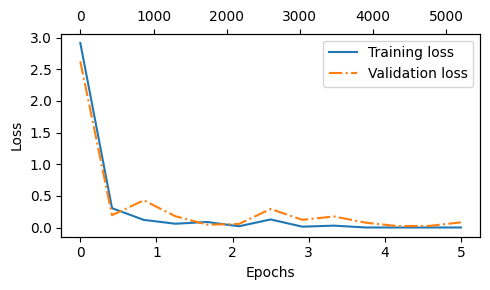

In [122]:
## plotting classification loss
import matplotlib.pyplot as plt

def plot_values(epochs_seen,examples_seen,train_values,val_values,label="loss"):
  fig,ax1 = plt.subplots(figsize=(5,3))
  ax1.plot(epochs_seen,train_values,label=f"Training {label}")
  ax1.plot(epochs_seen,val_values,linestyle="-.",label=f"Validation {label}")
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel(label.capitalize())
  ax1.legend()

  ax2 = ax1.twiny()
  ax2.plot(examples_seen,train_values,alpha=0)

  fig.tight_layout()
  plt.show()

epochs_tensor = torch.linspace(0,num_epochs,len(train_losses))
examples_seen_tensor = torch.linspace(0,examples_seen,len(train_losses))

plot_values(epochs_tensor,examples_seen_tensor,train_losses,val_losses)

* As we can see from the plot above, based on the sharp downward slope, the model is learning well from the training data, and there is little to o indicationof overfiiting i.e there is no noticeable gap between the training and validation set losses.

In [125]:
train_acc = accuray_loader(
    train_loader,model,device
)
val_accuracy = accuray_loader(
    val_loader,model,device
)
test_accuracy = accuray_loader(
    test_loader,model,device
)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")


Training accuracy: 46.25%
Validation accuracy: 98.66%
Test accuracy: 97.67%


## 1.8 Using the LLM as a spam classifier

In [126]:
def classify_review(text,model,tokenizer,device,max_length=None,pad_token_id=50256):
  model.eval()

  input_ids = tokenizer.encode(text)
  supported_context_length = model.pos_emb.weight.shape[1]

  input_ids = input_ids[:min(max_length,supported_context_length)]
  input_ids += [pad_token_id] * (max_length - len(input_ids))
  input_tensor = torch.tensor(input_ids,device=device).unsqueeze(0)

  with torch.no_grad():
    logits = model(input_tensor)[:,-1,:]
  predicted_label =torch.argmax(logits,dim=-1).item()

  return "spam" if predicted_label == 1 else "not spam"

In [127]:
text_1 = (
     "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)
print(classify_review(text_1,model,tokenizer,device,max_length=train_dataset.max_length))

spam


In [128]:
text_2 = (
     "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)
print(classify_review(text_2,model,tokenizer,device,max_length=train_dataset.max_length))

not spam


In [129]:
##saving the model
torch.save(model.state_dict(),"review_classifier.pth")


In [130]:
model_state_dict = torch.load("review_classifier.pth",map_location=device)
model.load_state_dict(model_state_dict)

<All keys matched successfully>